In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from libpysal.weights import fuzzy_contiguity
import json
import dask
from dask import delayed, dataframe as dd
from dask.distributed import Client, LocalCluster
from dask.graph_manipulation import bind
import bokeh
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
import glob
import dask.bag as db
from itertools import chain
import json
import warnings
import matplotlib.pyplot as plt
import logging
import dask.config

/tmp/ipykernel_6056/3223235786.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
with open('./out/singapore/clustertess.json', 'r') as f:
    includes_dict = json.load(f)

In [3]:
chunks = gpd.read_parquet('./out/singapore/clusters.pq')

In [4]:
w = fuzzy_contiguity(chunks, buffering=True, buffer=1000)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 3.
  warnings.warn(message)


<Axes: >

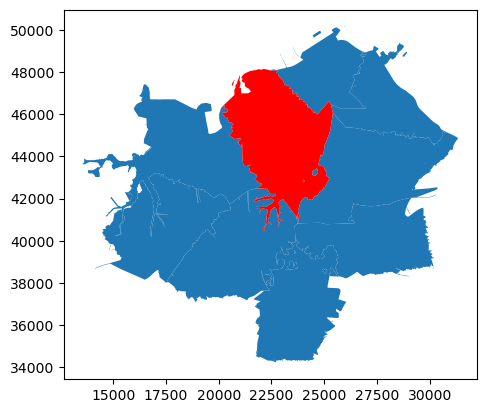

In [5]:
ax = chunks.loc[w.neighbors[2]].plot()
chunks.loc[[2]].plot(ax=ax, color='r')

In [6]:
import dask
dask.config.set({'logging.distributed': 'error'})

In [7]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

2023-03-24 19:27:04,461 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,462 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,464 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,466 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,467 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,470 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,471 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


2023-03-24 19:27:04,473 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 62.02 GiB


In [8]:
def duplicates(tessellation):

    # Check for duplicates based on UID
    duplicates = tessellation[tessellation.duplicated(subset='uID', keep=False)]

    # duplicates.to_file( "./out/" + place + 'errors.shp', driver='ESRI Shapefile')

    # Print the duplicate rows
    if len(duplicates) > 0:
        raise Exception("Tesselation: Duplicate UID entries:")
    elif (tessellation["uID"].isnull().values.any()):
        raise Exception("uID column include invalid entries")
    else:
        print("combined_chunk no problems")
        return 0

In [9]:
queen_out = {}

@delayed
def neigh_look(cell_id, main_chunk_ids, combined_chunks): 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        cell_poly = combined_chunks.loc[combined_chunks['uID'] == cell_id]
        neighbours = combined_chunks[~combined_chunks.geometry.disjoint(cell_poly)]
        return neighbours.uID.tolist()

def expand_one_order(n1, main_chunk_ids, added_cells_ids, order, combined_chunks):
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
    
        print("starting expand_one_order, chunk " + str(n1) + " order " + str(order), flush=True)
                
        if order == 0:
            return main_chunk_ids
        
        if len(added_cells_ids) == 0:
            added_cells_ids = main_chunk_ids

        results = db.from_sequence(main_chunk_ids)
        
        chunk_size = 16
        added_cells_ids_chunks = [added_cells_ids[i:i+chunk_size] for i in range(0, len(added_cells_ids), chunk_size)]
        
        len_sublist = len(added_cells_ids_chunks)
        for i, sublist in enumerate(added_cells_ids_chunks):

            delay_objs =[]
            new_results = []
                
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=UserWarning)
                delay_objs = [neigh_look(cell_id, main_chunk_ids, combined_chunks) for cell_id in sublist]
                new_results = dask.compute(delay_objs)
                new_results_bag = db.from_sequence(chain(*new_results[0]))
                results = db.concat([results, new_results_bag]).distinct()
                
                        
            print("compute done this wave", flush=True)
            print("chunk " + str(n1) + " , order " + str(order) +" , sublist " + str(i) + " of " + str(len_sublist), flush=True)
                
        expanded_cells = list(results.compute())

        neighbouring_cells = [cell for cell in added_cells_ids if cell not in main_chunk_ids]
        print("cells added this wave", flush=True)
    
    return expand_one_order(n1, expanded_cells, neighbouring_cells, order-1, combined_chunks)
    
def process_chunk(n1, order, neighbours, chunk):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
            
        main_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n1)}.pq")
        combined_chunks = main_chunk

        main_chunk_ids = list(main_chunk['uID'])
        results = []

        for n2 in neighbours:
            neigh_chunk = gpd.read_parquet(f"./out/singapore/tess_chunk_{int(n2)}.pq")
            combined_chunks = combined_chunks.append(neigh_chunk)

        combined_chunks = combined_chunks.reindex()
        
        chunk_boundary = []
        
        buffer = gpd.GeoDataFrame(geometry = [chunk.boundary[n1].buffer(5)], crs=main_chunk.crs)
        
        # find the rows in main_chunk that intersect the buffered polygon
        intersecting_rows = gpd.sjoin(main_chunk, buffer, how='inner', op='intersects')
        
        # intersecting_rows.plot(figsize=(5, 5))
        # plt.show()
        
        out = expand_one_order(n1, main_chunk_ids, intersecting_rows["uID"].tolist(), order, combined_chunks)
        
        return out

# for n1 in tqdm(range(10), total=10):
#     queen_out[n1] = process_chunk(n1)

file_pattern = "./out/singapore/tess_chunk_*.pq"
file_list = glob.glob(file_pattern)
num_files = len(file_list)

# combined_chunks=[]
# delayed_tasks = []
# for n1 in range(num_files):
#     delayed_task = process_chunk(n1, w, combined_chunks)
#     delayed_tasks.append(delayed_task)

#     results = delayed_tasks

queen_out = [process_chunk(n1, 3, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]


for n1 in tqdm(range(num_files)):
    queen_out[n1].to_parquet(f"./out/singapore/queen_{int(n1)}.pq")

/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_chunks = combined_chunks.append(neigh_chunk)
/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_chunks = combined_chunks.append(neigh_chunk)
/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_chunks = combined_chunks.append(neigh_chunk)
/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_chunks = combined_chunks.append(neigh_chunk)
/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated a

/tmp/ipykernel_6056/3086505602.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_chunks = combined_chunks.append(neigh_chunk)


/tmp/ipykernel_6056/3086505602.py:98: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  queen_out = [process_chunk(n1, 3, w.neighbors[n1], chunks.loc[[n1]]) for n1 in range(num_files)]


starting expand_one_order, chunk 0 order 3


/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  return pickle.loads(x)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use Py

/home/ubuntu/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


compute done this wave


chunk 0 , order 3 , sublist 0 of 31


compute done this wave


chunk 0 , order 3 , sublist 1 of 31


compute done this wave


chunk 0 , order 3 , sublist 2 of 31


/home/ubuntu/miniconda3/lib/python3.10/site-packages/geopandas/geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


compute done this wave


chunk 0 , order 3 , sublist 3 of 31


2023-03-24 19:28:32,443 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


compute done this wave


chunk 0 , order 3 , sublist 4 of 31


2023-03-24 19:28:40,073 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


2023-03-24 19:28:47,006 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2023-03-24 19:28:47,261 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2023-03-24 19:28:47,611 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2023-03-24 19:28:49,157 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


2023-03-24 19:28:49,344 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


2023-03-24 19:28:49,565 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


compute done this wave


chunk 0 , order 3 , sublist 5 of 31


In [ ]:
daskCluster.close()
client.shutdown()


In [ ]:
queen_out.to_parquet("./out/singapore/queen_areas.pq")